## Validate vs Ember

In [2]:
""" Boiler plate
- import all packages
- emulate snakemake so can load config as usual
- load the network you want
TODO: make it easier to restore old runs
TODO: hide all the boiler pates in a file
"""
%load_ext autoreload
%autoreload 2
%precision %e

import logging
import pypsa
import os.path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# running the jupyter notebook on the compute nodes doesnt build the path as expected, you have to manually do this
import IPython
from IPython.utils import io
import seaborn as sns
import requests
import itertools

working_directory = os.path.dirname(IPython.extract_module_locals()[1]['__vsc_ipynb_file__'])
workflow_dir = os.path.dirname(working_directory)
scripts_dir = os.path.join(workflow_dir, "scripts")
root_dir = os.path.dirname(workflow_dir)

os.chdir(scripts_dir)


logging.basicConfig(level=logging.CRITICAL)
logger = logging.getLogger(__name__)


from _helpers import configure_logging, mock_snakemake
# from make_summary import assign_carriers
import _plot_utilities
import plot_network 
logging.getLogger('plot_network').setLevel(logging.CRITICAL)
logging.getLogger('_plot_utilities').setLevel(logging.CRITICAL)

from constants import PLOT_COST_UNITS, PLOT_CAP_UNITS,PLOT_SUPPLY_UNITS
from _plot_utilities import fix_network_names_colors, determine_plottable
from plot_network import plot_cost_map, plot_map

In [16]:
import yaml

REMIND_COUPLED = True
PLANNING_YEAR = 2025
config = None if not REMIND_COUPLED else "resources/tmp/remind_coupled.yaml"
# config = None if not REMIND_COUPLED else "resources/tmp/tmp.yaml"

with open(os.path.join(root_dir, config), "r") as f:
    yaml_config = yaml.safe_load(f)
co2_pathway = yaml_config["scenario"]["co2_pathway"][0]

snakemake = mock_snakemake(
    "plot_network",
    snakefile_path=workflow_dir,
    topology="current+FCG",
    co2_pathway=co2_pathway,
    planning_horizons=PLANNING_YEAR,
    configfiles = config,
    # heating_demand="positive",
)

configure_logging(snakemake, logger=logger)
config = snakemake.config
tech_colors = config["plotting"]["tech_colors"]


ntw_path = snakemake.input.network
# ntw_path = f"/home/ivanra/downloads/PaperResultsXiaowei_networks/postnetwork-ll-current+Neighbor-exponential175-{PLANNING_YEAR}.nc"
# ntw_path = "/p/tmp/ivanra/xiaowei-pypsa/PyPSA-China/results/version-0325.175.1H/postnetworks/positive/postnetwork-ll-current+Neighbor-exponential175-2060.nc"
print(f"Loading network from {ntw_path}")
n = pypsa.Network(ntw_path)
results_dir = os.path.dirname(os.path.dirname(ntw_path))
weighting = n.snapshot_weightings.iloc[0,0]


fix_network_names_colors(n, config)
determine_plottable(n) ; 

2025-07-28 14:31:08,998 - _helpers.py - INFO - =========== NEW RUN ===========
2025-07-28 14:31:08,998 - _helpers.py - INFO - =========== NEW RUN ===========
INFO:__main__:=========== NEW RUN ===========


Loading network from /p/tmp/ivanra/PyPSA-China-PIK/results/v-1.1.1_REMIND_EFC_2025-07-25_r6_frozen_except_CCS_moreexp2/overnight_co2pw-SSP2-PkBudg1000-CHA-pypsaelh2_higheradj_topo-current+FCG/postnetworks/ntwk_2025.nc


/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/_plot_utilities.py:280: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





# get Ember

In [17]:

with open("../../resources/apikeys/ember.txt", "r") as f:
    my_api_key = f.read()
base_url = "https://api.ember-energy.org"
query_url = (
  f"{base_url}/v1/electricity-generation/yearly"
  + f"?entity_code=CHN&is_aggregate_series=false&start_date=2015&api_key={my_api_key}"
)
response = requests.get(query_url)
if response.status_code == 200:
    data = response.json()



ember_data = pd.DataFrame.from_records(data["data"])
year = str(min(2024,int(PLANNING_YEAR)))
ember_yr = ember_data.query("date==@year").set_index("series")
ember_yr.index = ember_yr.index.str.lower()
ember_yr.rename({"bioenergy": "biomass", "hydro": "hydroelectricity"}, inplace=True)

len_= ember_yr.shape[0]
ember_yr = ember_yr.loc[["coal" ,"biomass" , "gas", "other fossil", "wind","solar","nuclear", "hydroelectricity", "net imports"]]
assert len_ == ember_yr.shape[0], "The order of the rows has changed, please check the code"

In [18]:
# Use a sequence of default matplotlib colors for the pie chart
colors_ember = ember_yr.rename({"wind":"onwind"}).index.map(n.carriers.color).to_list()
default_colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for i, c in enumerate(colors_ember  ):
    if pd.isna(c):
        colors_ember[i] = next(default_colors)
labels_ember = [f"{idx} ({val:.1f}%)" for idx, val in ember_yr.share_of_generation_pct.items()]

In [19]:
eb = n.statistics.energy_balance(groupby=pypsa.statistics.get_carrier_and_bus_carrier, comps = ["Generator", "Link"])
ac_balance = eb.reset_index().query("bus_carrier == 'AC'").groupby("carrier").sum()
ac_balance.rename(columns={0:"AC supply"}, inplace=True)
ac_balance = ac_balance[ac_balance["AC supply"] > 0]["AC supply"]
if "battery discharger" in ac_balance.index:
    ac_balance.drop("battery discharger", inplace=True)

# Calculate percentage labels
ac_balance_mod = ac_balance.copy()
gas_sum = ac_balance_mod.get("Open-Cycle Gas", 0) + ac_balance_mod.get("Combined-Cycle Gas", 0)
ac_balance_mod = ac_balance_mod.drop(["Open-Cycle Gas", "Combined-Cycle Gas"], errors="ignore")
ac_balance_mod.loc["Gas"] = gas_sum
total = ac_balance_mod.sum()
# Drop entries with less than 0.1%
ac_balance_mod = ac_balance_mod[ac_balance_mod / total >= 0.001]
if (total - ac_balance_mod.sum()) / total >= 0.001:
    ac_balance_mod.loc["Other"] = total - ac_balance_mod.sum()

plot_list = ["Coal", "biomass", "Gas", "Coal Power Plant"  ,"Onshore Wind","Offshore Wind","Solar","nuclear", "Hydroelectricity", "Other"]
missing = set(plot_list) - set(ac_balance_mod.index)
if missing:
    print(f"Warning: The following entries are missing from the balance: {missing}")
mask = ac_balance_mod.index.isin(plot_list)
ac_balance_mod= ac_balance_mod.loc[[c for c in plot_list if c in ac_balance_mod.index]]
colors = ac_balance_mod.index.map(n.carriers.set_index("nice_name").color)
colors = colors.fillna("lightgrey")  # Fill NaN colors with light grey
total = ac_balance_mod.sum()
labels = [f"{idx.replace("Power Plant", "")} ({val/total:.1%})" for idx, val in ac_balance_mod.items()]

ac_balance_mod.name = ""


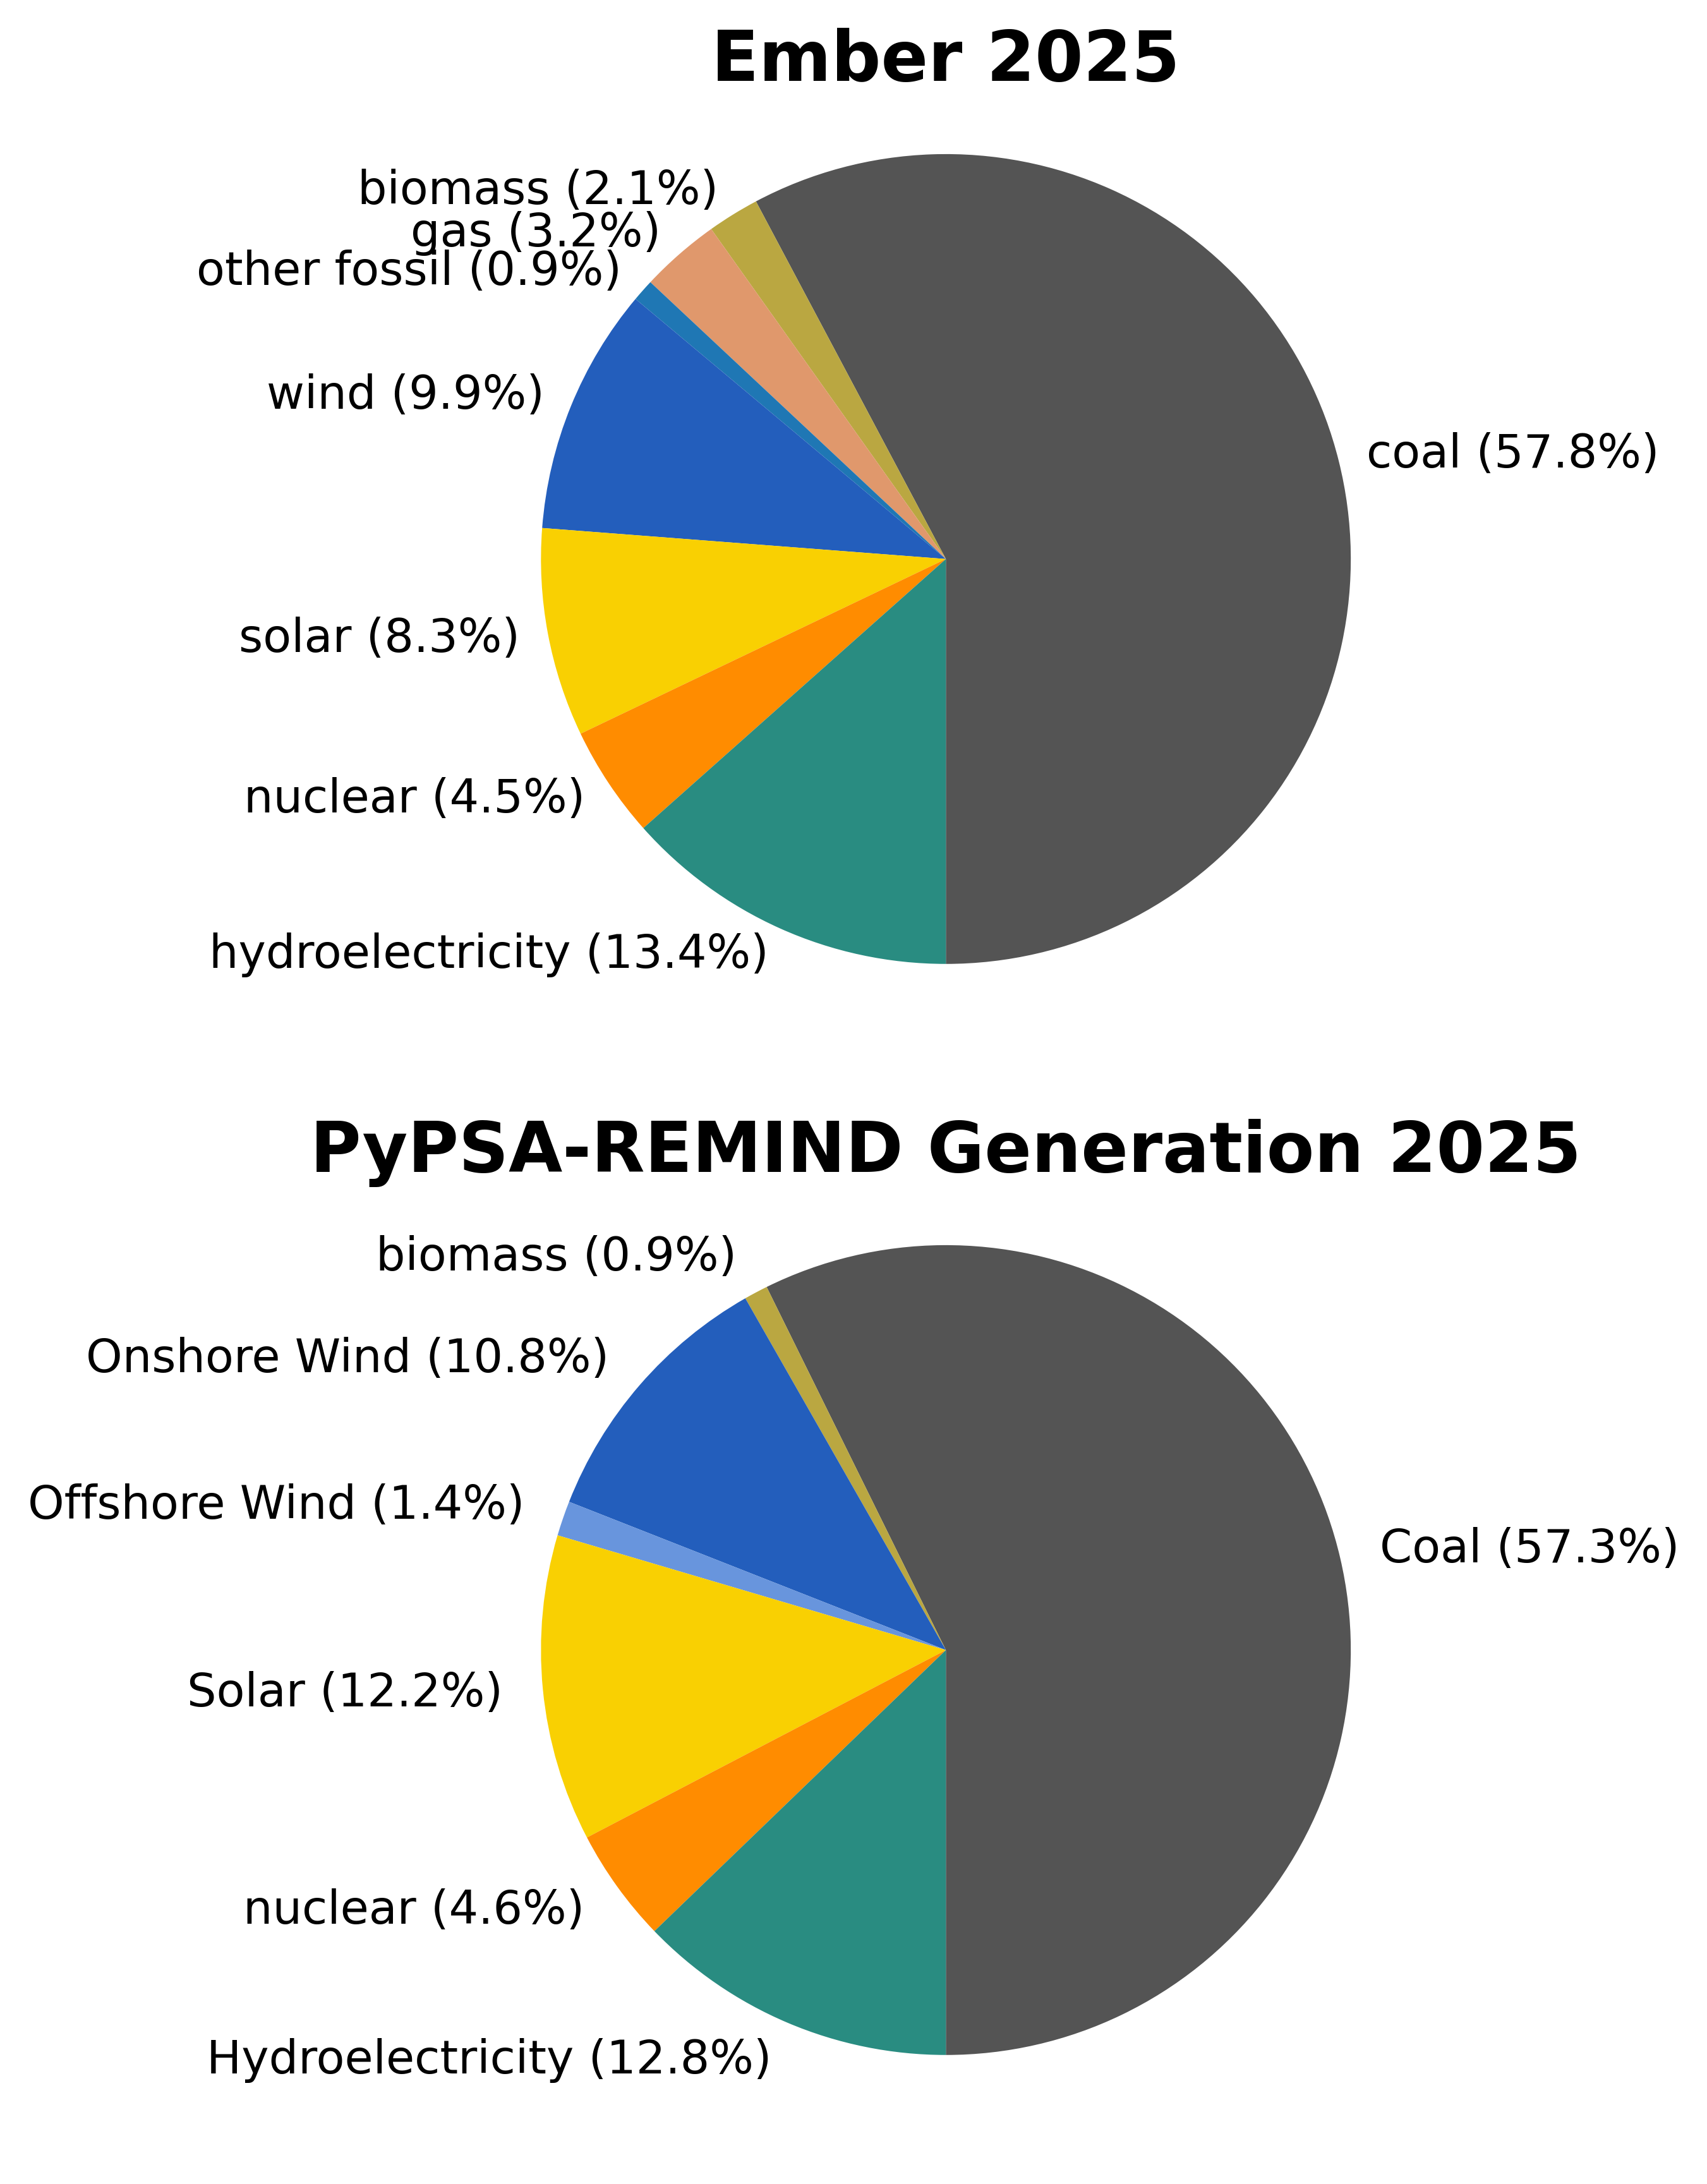

In [25]:
fig, axes = plt.subplots(2,1,  figsize=(20, 8),)
ember_yr.share_of_generation_pct.clip(0).plot.pie(
    colors=colors_ember,

    labels=labels_ember,
    textprops={'fontsize': 12},
    legend=False,
    labeldistance=1.07,  # Move labels outward to reduce overlap
    startangle = 270,
    ax = axes[0]
)
axes[0].set_title(f"Ember {PLANNING_YEAR}", fontsize=18, weight="580", fontname = "sans-serif", y=0.95);

axes[0].set_ylabel("")
ac_balance_mod.plot.pie(
    colors=colors,
    labels=labels,
    autopct=None,
    textprops={"fontsize": 12},
    startangle=270,
    ax = axes[1]
)
axes[1].set_ylabel("")
axes[1].set_title(f"PyPSA-REMIND Generation {PLANNING_YEAR}", fontsize=18, weight="580", fontname = "sans-serif", y=0.95);
fig.tight_layout()
fig.set_dpi(440);


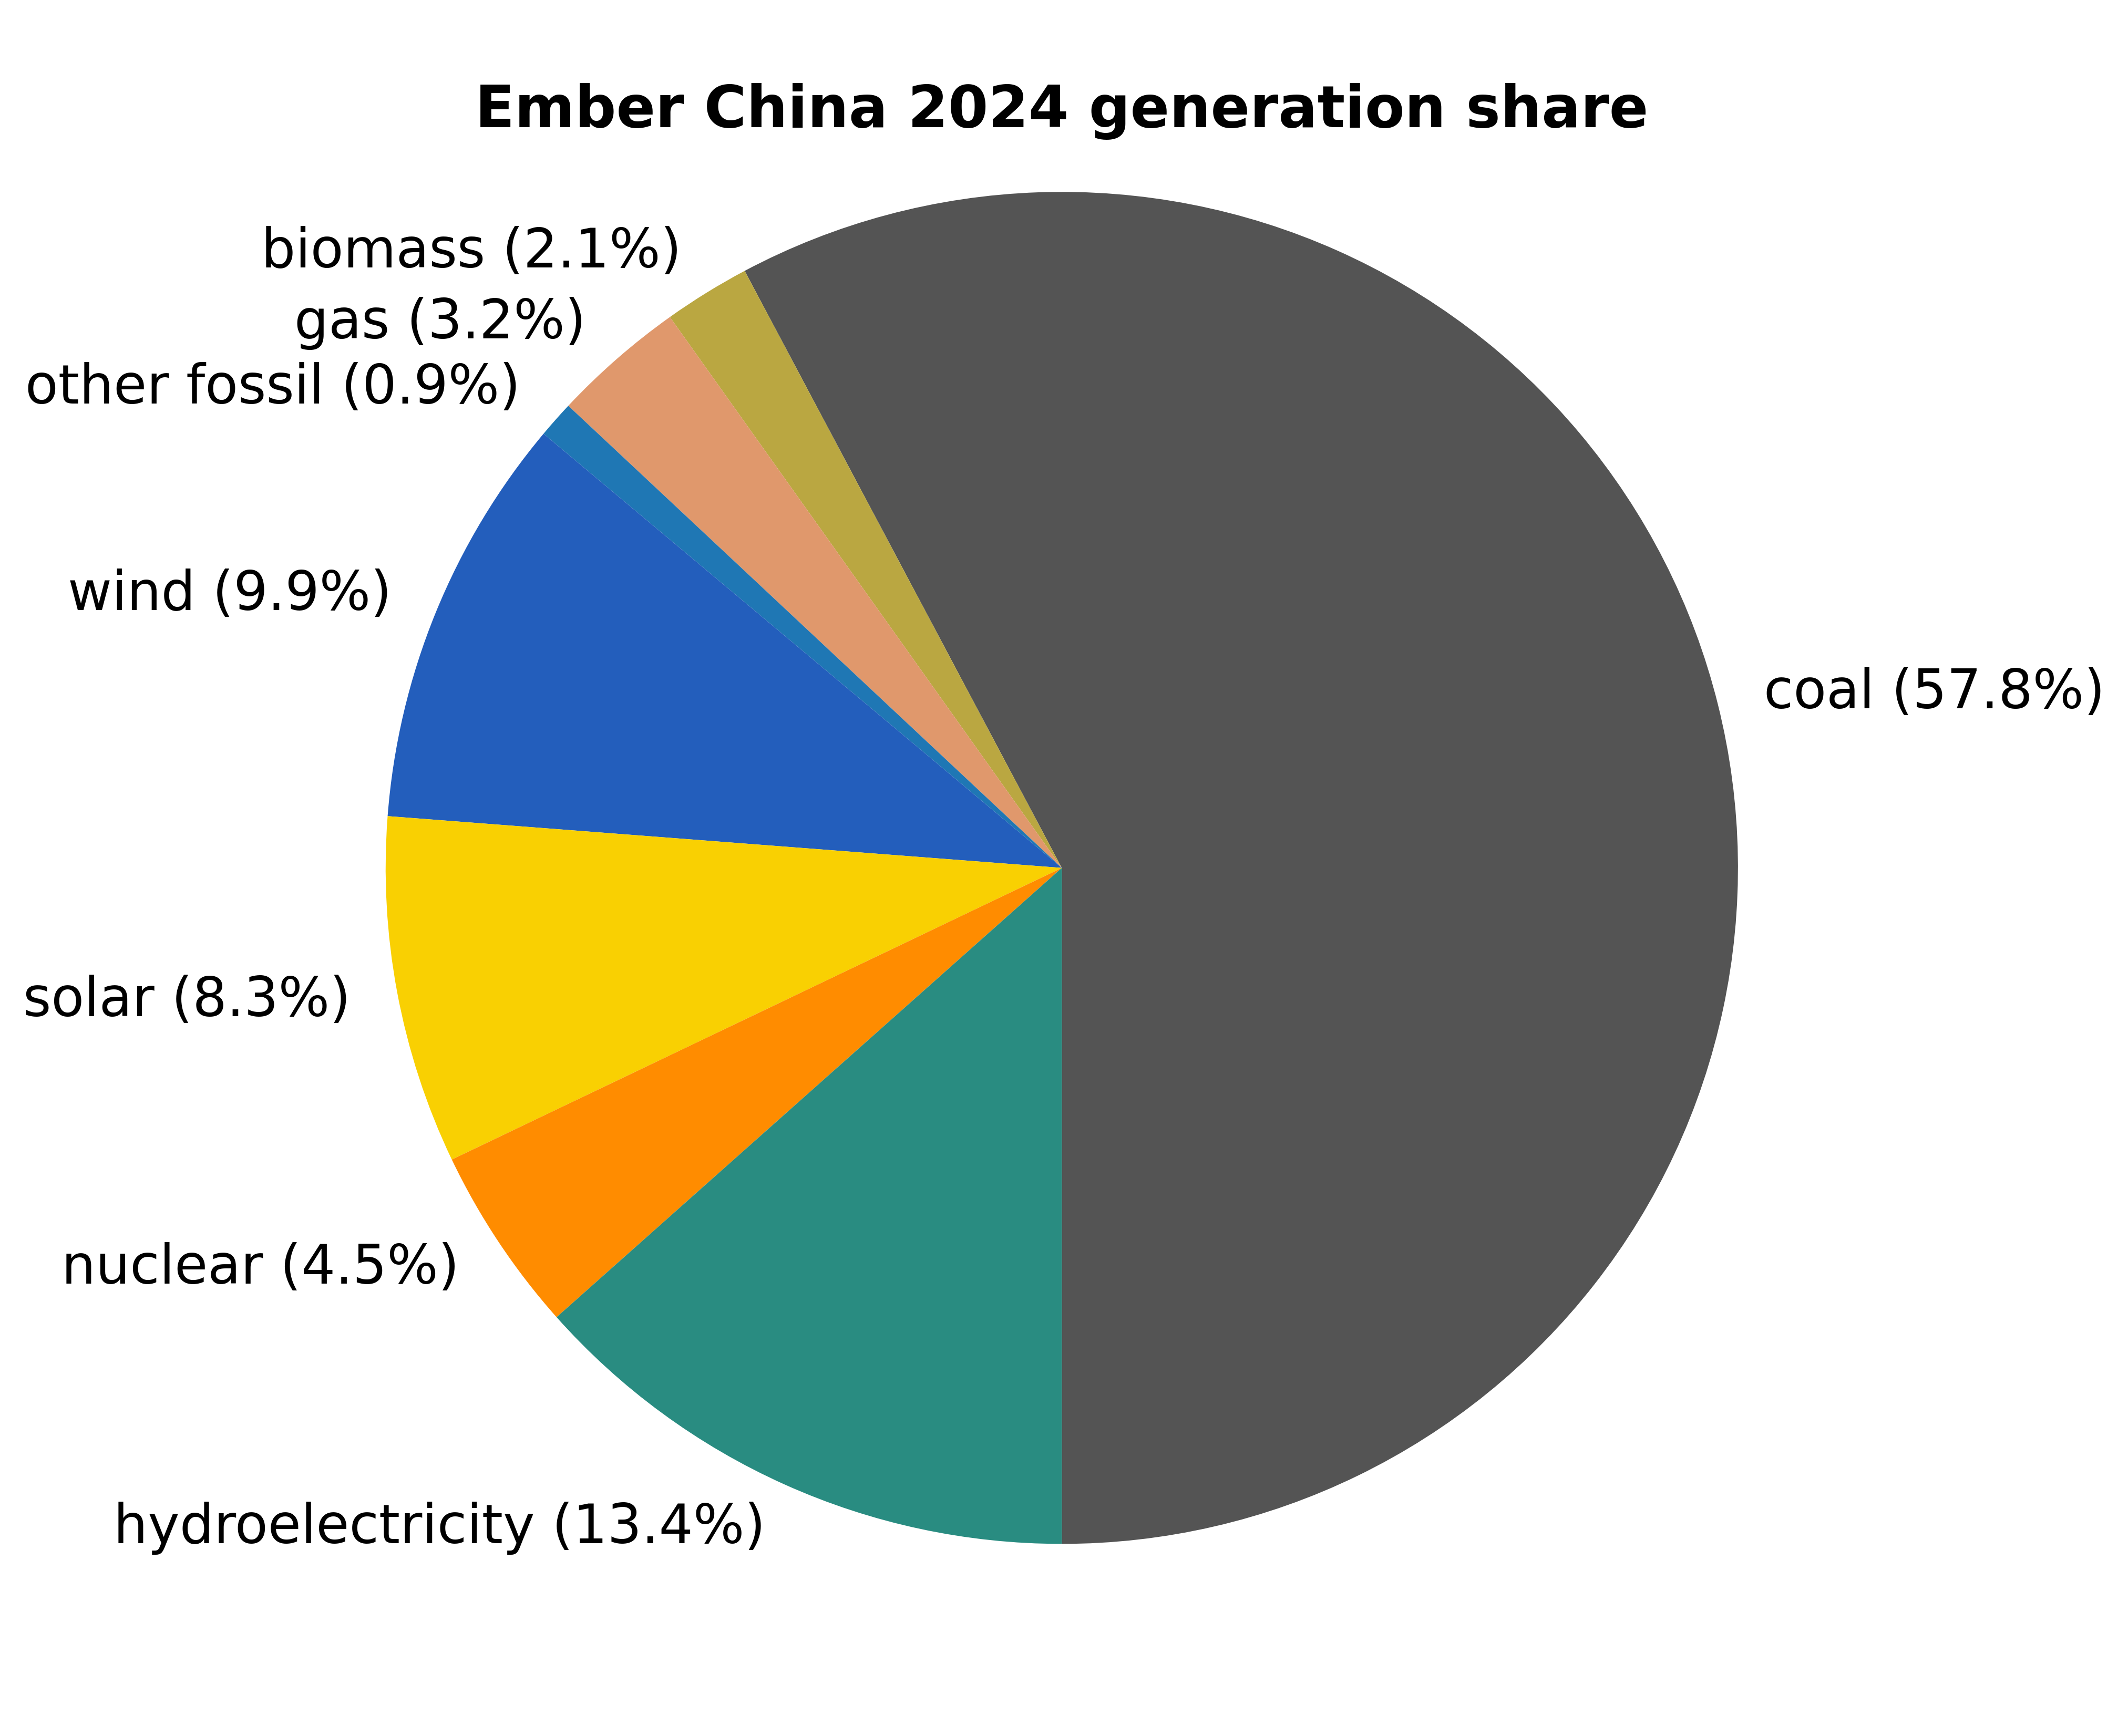

In [21]:
ax = ember_yr.share_of_generation_pct.clip(0).plot.pie(
    colors=colors_ember,
    figsize=(10, 8),
    labels=labels_ember,
    textprops={'fontsize': 16.8},
    legend=False,
    labeldistance=1.07,  # Move labels outward to reduce overlap
    startangle = 270,
)
ax.set_ylabel("")
fig = ax.get_figure()
fig.suptitle(f"Ember China {year} generation share", fontsize=18, weight="580", fontname="sans-serif")
fig.tight_layout()
fig.suptitle(f"Ember China {year} generation share", fontsize=18, weight="580", fontname="sans-serif", y=0.9)
# fig.subplots_adjust(top=0.85)
fig.tight_layout()
fig.set_dpi(440);



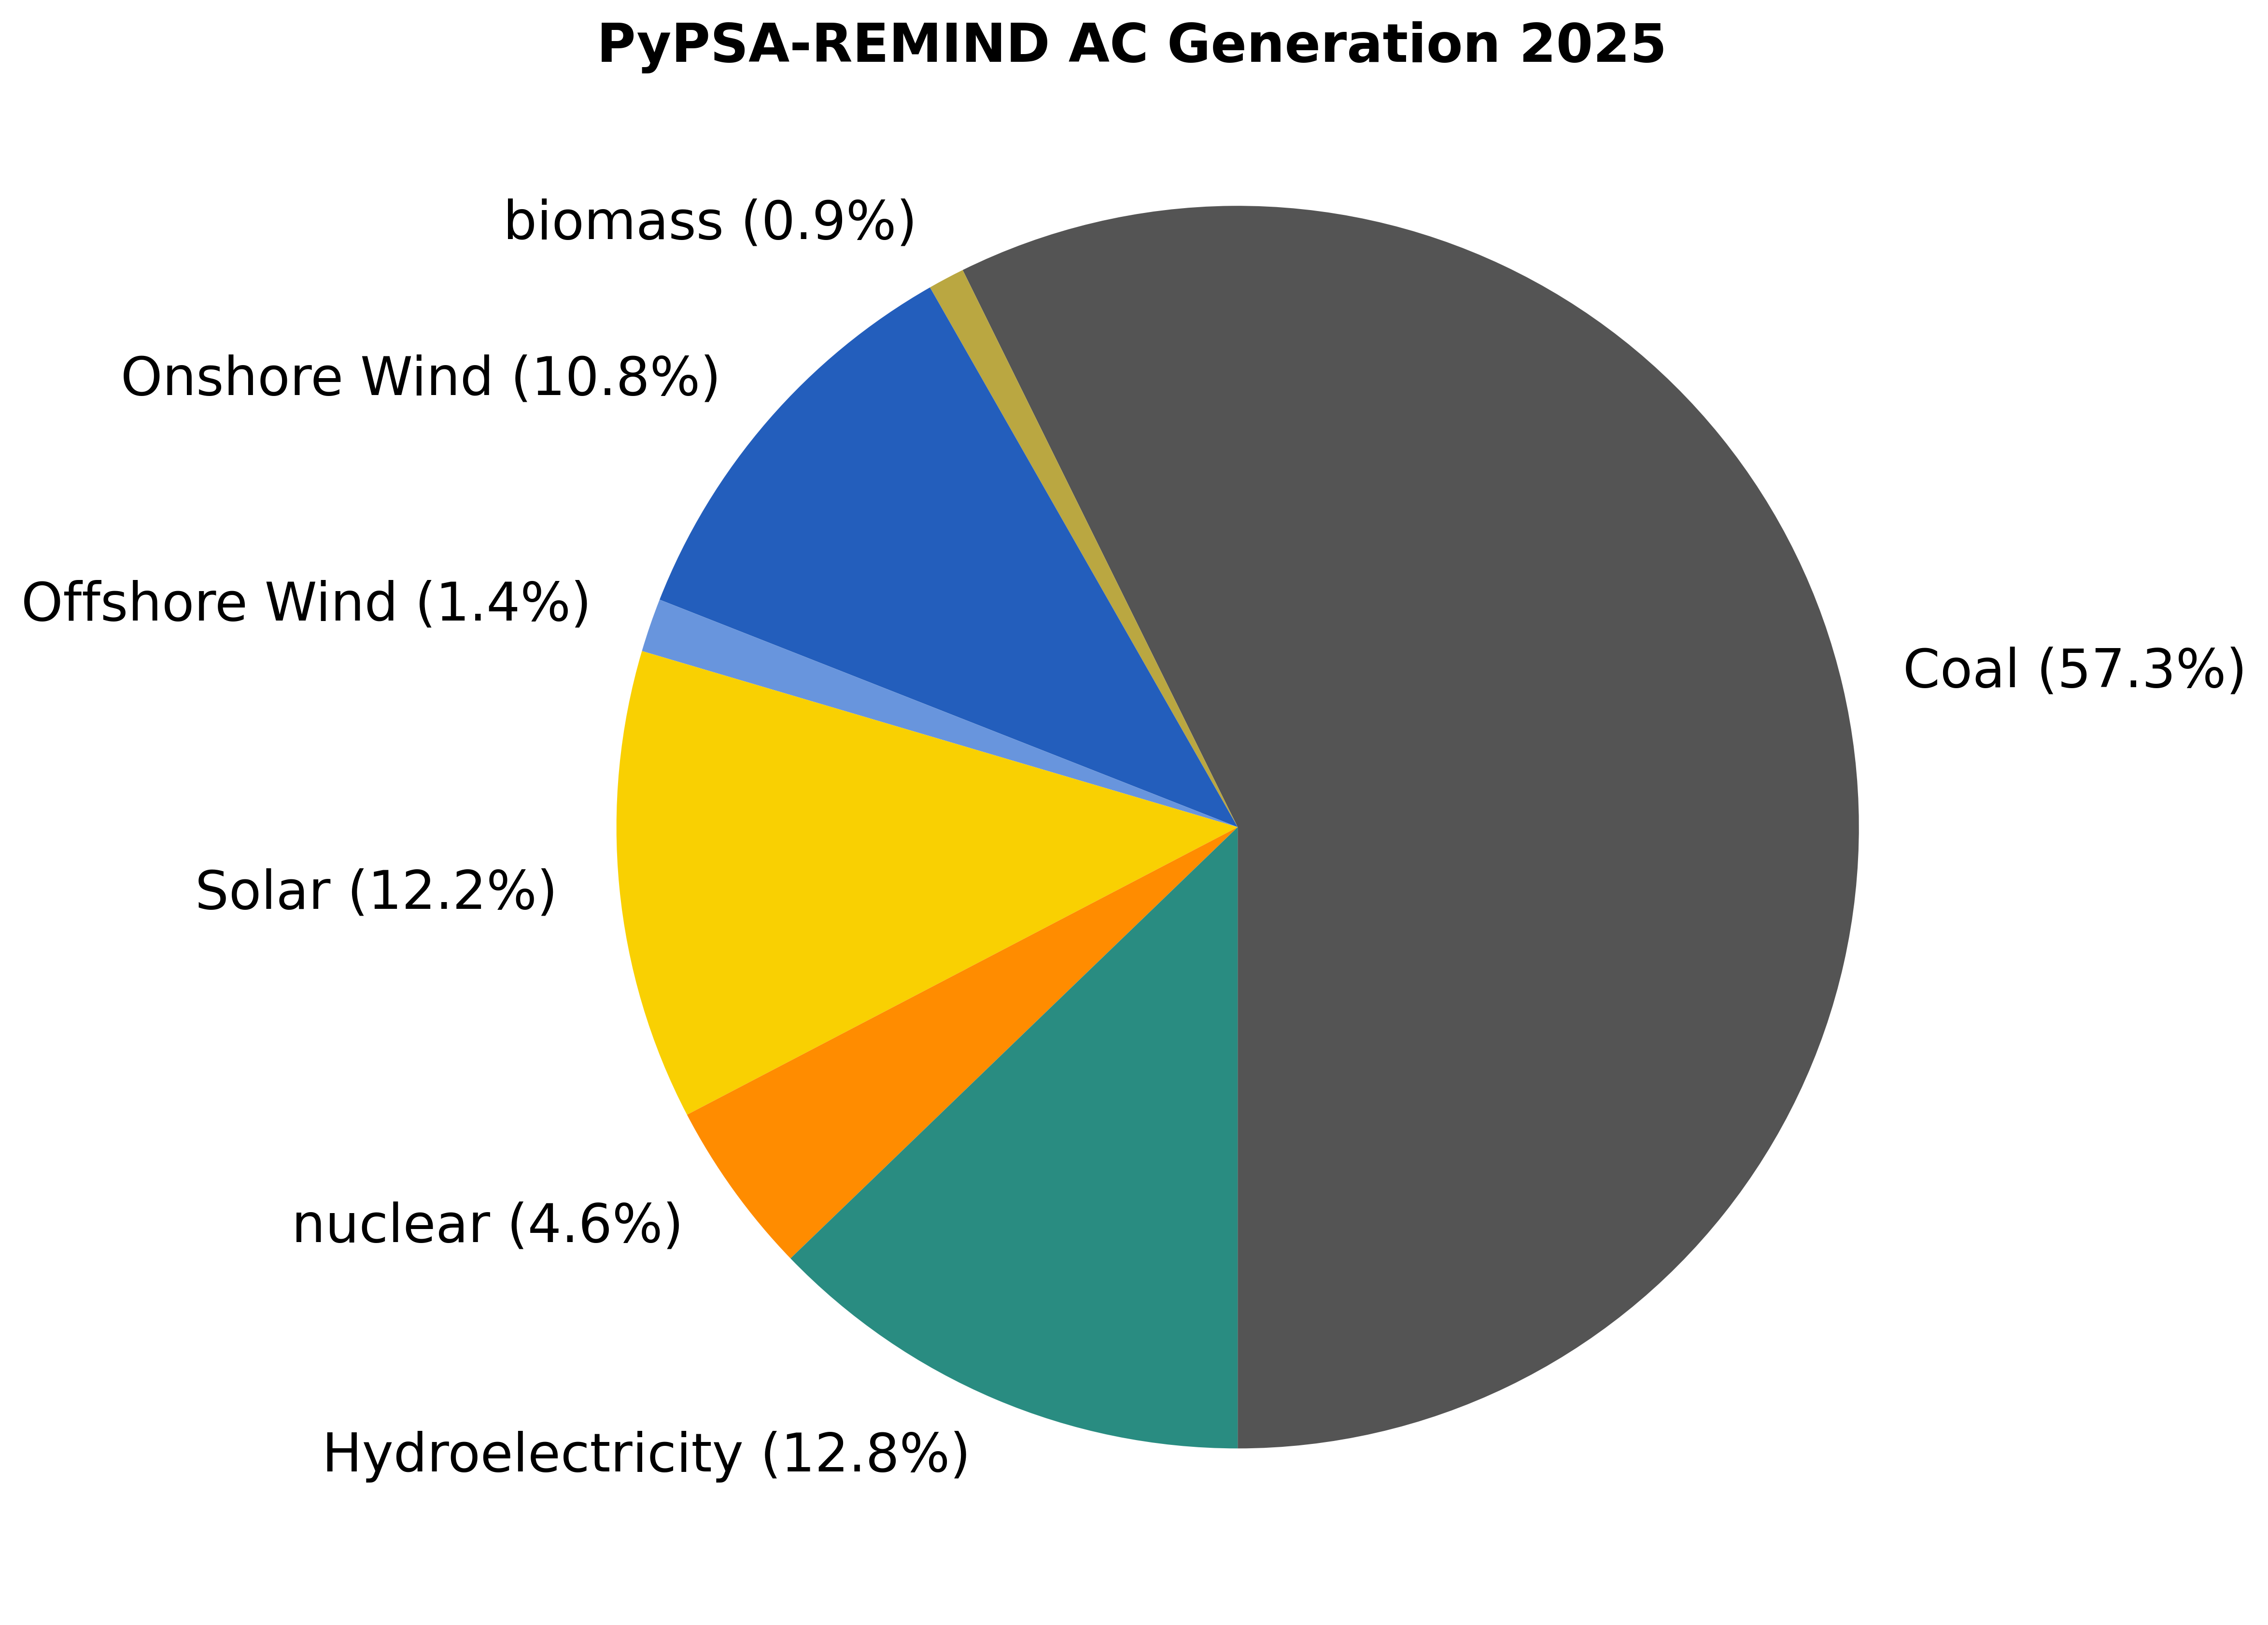

In [22]:
ax = ac_balance_mod.plot.pie(
    colors=colors,
    labels=labels,
    autopct=None,
    figsize=(10, 8),
    textprops={"fontsize": 18},
    startangle=270,
)
fig = ax.get_figure()
fig.suptitle(f"PyPSA-REMIND AC Generation {PLANNING_YEAR}", fontsize=18, weight="580", fontname = "sans-serif", y=0.95);
fig.tight_layout()
fig.set_dpi(440);
